<a href="https://colab.research.google.com/github/ratel0307/Deep-Learning/blob/main/5%EC%9E%A5_%EC%98%A4%EC%B0%A8%EC%97%AD%EC%A0%84%ED%8C%8C%EB%B2%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 5.4 단순한 계층 구현하기

In [ ]:
# 5.4.1 곱셈 계층

class MulLayer:
  def __init__(self):
    self.x = None
    self.y = None

  def forward(self, x, y):
    self.x = x
    self.y = y
    out = x * y

    return out

  def backward(self, dout):
    dx = dout * self.y
    dy = dout * self.x

    return dx, dy


In [ ]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [ ]:
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


In [ ]:
# 5.4.2 덧셈 계층

class AddLayer:
  def __init__(self):
    pass

  def forward(self, x, y):
    out = x + y
    return out

  def backward(self, dout):
    dx = dout * 1
    dy = dout * 1
    return dx, dy

In [ ]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(price)
print(dapple_num, dapple, dorange, dorange_num, dtax)

715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


## 5.5 활성화 함수 계층 구현하기

In [ ]:
# 5.5.1 ReLU 계층

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [ ]:
# 5.5.2 Sigmoid 계층

class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1 / (1 + np.exp(-x))
    self.out = out
    return out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out
    return dx

## 5.6 Affine/Softmax 계층 구현하기

In [ ]:
# 5.6.1 Affine 계층

# 5.6.2 배치용 Affine 계층

import numpy as np

X_dot_W = np.array([[0, 0, 0], [10, 10, 10]])
B = np.array([1, 2, 3])

X_dot_W + B

array([[ 1,  2,  3],
       [11, 12, 13]])

In [ ]:
dY = np.array([[1, 2, 3], [4, 5, 6]])
dY

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
dB = np.sum(dY, axis=0)
dB

array([5, 7, 9])

In [ ]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x = x
    out = np.dot(x, self.W) + self.b

    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)
    return dx

In [ ]:
## 5.3.6 Sofmax-with-Loss 계층

import numpy as np

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)

  batch_size = y.shape[0]
  return -np.sum(t * np.log(y + 1e-7)) / batch_size

class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.t)
    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    dx = (self.y - self.t) / batch_size

    return dx

## 5.7 오차역전파법 구현하기

In [ ]:
# 5.7.2 오차역전파법을 적용한 신경망 구현하기

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val # 값 복원
        it.iternext()

    return grad

from collections import OrderedDict

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        #계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
          x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
      #순전파
      self.loss(x, t)

      #역전파
      dout = 1
      dout = self.lastLayer.backward(dout)

      layers = list(self.layers.values())
      layers.reverse()
      for layer in layers:
        dout = layer.backward(dout)

      #결과 저장
      grads = {}
      grads['W1'] = self.layers['Affine1'].dW
      grads['b1'] = self.layers['Affine1'].db
      grads['W2'] = self.layers['Affine2'].dW
      grads['b2'] = self.layers['Affine2'].db

      return grads

In [ ]:
# 5.7.3 오차역전파법으로 구한 기울기 검증하기

import numpy as np
import sys, os
sys.path.append('/content/drive/MyDrive/deep-learning-from-scratch/dataset') #구글 드라이브와 연결합니다.
from mnist import load_mnist #dataset.mnist가 아닌 그냥 mnist입니다!

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 절대 오차의 평균을 구한다.
for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) ) #abs: 절댓값
    print(key + ":" + str(diff))

W1:5.442425701659973e-10
b1:3.150058967826006e-09
W2:5.9092905362870595e-09
b2:1.3992391164202588e-07


In [ ]:
# 5.7.4 오차역전파법을 사용한 학습 구현하기

import sys, os
sys.path.append('/content/drive/MyDrive/deep-learning-from-scratch/dataset') #구글 드라이브와 연결합니다.
from mnist import load_mnist #dataset.mnist가 아닌 그냥 mnist입니다!

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_poch = max(train_size / batch_size, 1)

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  grad = network.gradient(x_batch, t_batch)

  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]

  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  if i % iter_per_poch == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(train_acc, test_acc)

0.13401666666666667 0.1333
0.89865 0.9018
0.9215166666666667 0.9232
0.9328333333333333 0.9306
0.9438833333333333 0.9422
0.9506666666666667 0.9468
0.95625 0.9516
0.9613166666666667 0.9564
0.9637333333333333 0.9594
0.9658833333333333 0.9598
0.9692833333333334 0.9622
0.9703 0.9634
0.9723166666666667 0.9641
0.9746833333333333 0.9673
0.9758333333333333 0.9669
0.9768 0.9687
0.9785333333333334 0.9698


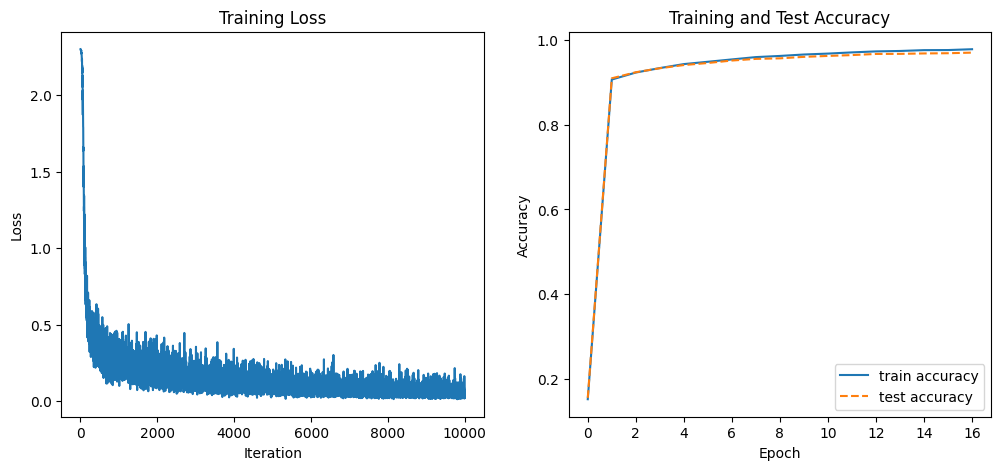

In [ ]:
#그래프로도 확인해봐요!

import matplotlib.pyplot as plt

# 손실 함수 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='train accuracy')
plt.plot(test_acc_list, label='test accuracy', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Test Accuracy")

plt.show()